In [1]:
import json, os, re, csv, datetime, gzip
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim

from gensim.models.ldamulticore import LdaMulticore


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')


topics_path = os.path.join('..', 'topics', 'topic.pickle')
data_path = os.path.join('..', 'data')
models_path = os.path.join('..', 'models')
project_data_path = os.path.join('..', 'project_data')

c:\users\giedrius\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\giedrius\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading https://bitcointalk.org data

In [4]:
%%time
#fileNames = ["Forum/" + pos_json for pos_json in os.listdir("Forum/") if pos_json.endswith('.json')]
#fileNames = 'Forum/bitcointalk_88.json'
fileNames = 'bitcoin.json'
with open(fileNames ,encoding="utf-8") as json_data:
    forum = json.load(json_data)['posts']

Wall time: 2.2 s


In [5]:
%%time
if 1==1:
    comments = [(datetime.datetime.strptime(rep["date"][:10], '%Y-%m-%d').date(),  rep["content"], dic["content"])
               for dic in forum  if 'replies' in dic 
               for rep in dic['replies'] if rep["content"] != []]
   
    
del forum

Wall time: 7.05 s


In [20]:
len(comments)

627122

In [3]:
# comments = []
# x_date = datetime.date(2011, 1, 1)
# date = datetime.date(2011, 1, 1)
# for dic in forum:
#     if dic['replies'] != []:
#         x_date = datetime.datetime.strptime(dic["date"][:10], '%Y-%m-%d').date()
#         com = dic["topic"] + dic["content"]
#         for replies in dic['replies']:
#             date = datetime.datetime.strptime(replies["date"][:10], '%Y-%m-%d').date()
#             if date != x_date:
#                 comments.append((x_date, com))
#                 com = '' 
#             else:
#                  com += replies["content"]
#             x_date = date 
            
# del forum        

In [6]:
%%time
#read pickle files
df = pd.DataFrame()
for file in os.listdir(data_path):
    help_df = pd.read_pickle(os.path.join(data_path, str(file)))
    help_df["Date"] = datetime.datetime.strptime(file, '%Y-%m-%d').date()
    df = pd.concat([df, help_df], ignore_index=True)

topics = pd.read_pickle(topics_path)

Wall time: 1min 14s


In [7]:
%%time
for i in range(len(topics)):
    index = df[df["Topic No."] == i].index[0]
    df.at[index, "Comment"] = topics.at[i,"Topic"] + topics.at[i,"Content"] + df.at[index, "Comment"]

Wall time: 1min 18s


In [8]:
df = df[(df['Date'] >= datetime.date(2014,1,1) )]

In [9]:
df = df[(df['Date'] < datetime.date(2019,1,1) )]

In [8]:
df[-5:]

,Topic No.,Comment,Date
1579032,14045,On average now Miner dismissed because of inco...,2018-12-31
1579033,14045,"For me, I don't think that a lots of miner's w...",2018-12-31
1579034,14045,"For me, I don't think that a lots of miner's w...",2018-12-31
1579035,14045,"If the existing miners stop producing bitcoin,...",2018-12-31
1579036,14045,there are 4 Million bitcoin that ready to mine...,2018-12-31


In [10]:
comments = df.groupby(["Date", "Topic No."])["Comment"].apply(lambda x: ''.join(x))

In [18]:
# %%time

# comments = []
# for i in range(len(data)):
#     comments.append((data.index[i][0], data.index[i][1] + data.index[i][2] + data[i]))

Wall time: 10.7 s


## Preprocessing data

In [10]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def preprocessText(text):
    text = text.lower()
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'web_url', text)
    text = re.sub('www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'web_url', text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r" u ", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"e mail", "email", text)
    words = text.split() 
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in stop_words and len(w) > 1]
    return meaningful_words
    #return ' '.join(meaningful_words)

In [26]:
lemmatizer = WordNetLemmatizer()

In [11]:
%%time
# 11 min
tokens = []
for i in range(0,len(comments)):
    if i % 20000 == 0:
        print(datetime.datetime.now().time(),i)
    tokens.append(preprocessText(comments[i]))

11:36:52.404542 0
11:37:45.215248 20000
11:39:26.184873 40000
11:41:03.012679 60000
11:43:03.303690 80000
11:44:51.761785 100000
11:46:16.319053 120000
11:47:41.843635 140000
Wall time: 11min 6s


In [12]:
from gensim.models import Phrases

In [13]:
bigram_model = Phrases(tokens)
#bigram_tokens = bigram_model[tokens]

In [14]:
%%time
bigram_tokens = []
for token in tokens:
    bigram_tokens.append(bigram_model[token])

In [15]:
del tokens

In [2]:
%%time
import gzip
if 1==0:
    with gzip.open(os.path.join(project_data_path, 'bigram_tokens'), 'wb') as f:
        pickle.dump(bigram_tokens, f, pickle.HIGHEST_PROTOCOL)
else:
    with gzip.open(os.path.join(project_data_path, 'bigram_tokens'), 'rb') as f:
        bigram_tokens = pickle.load(f)


Wall time: 13.7 s


##  Creating dictionary and corpus

In [3]:
%%time
from gensim import corpora, models
if 1==0:
    dictionary = corpora.Dictionary(bigram_tokens)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    dictionary.save(os.path.join(project_data_path, 'dictionary.dict'))
else:
    dictionary = corpora.Dictionary.load(os.path.join(project_data_path, 'dictionary.dict'))

Wall time: 20.1 ms


In [48]:
%%time
corpus = []
for i in range(0,len(bigram_tokens)):
    corpus.append(dictionary.doc2bow(bigram_tokens[i]))

Wall time: 42.9 s


In [2]:
if 1==0:
    with gzip.open(os.path.join(project_data_path, 'corpus'), 'wb') as f:
        pickle.dump(corpus, f, pickle.HIGHEST_PROTOCOL)
else:
    with gzip.open(os.path.join(project_data_path, 'corpus'), 'rb') as f:
        corpus = pickle.load(f)

## Create LDA model

In [15]:
import gensim
import pyLDAvis
import pyLDAvis.gensim
import pickle

In [50]:
%%time
#With not lemmatizated corpus LDA(topics=40, passes=2) => Wall time: 9h 16min 19s
#Lemmatizated corpus LDA(topics=30, passes=5) => Wall time: 16h 53min 17s  => filename: lda
#Lemmatizated corpus (comments merged by topic and date) LDA(topics=40, passes=10) => Wall time: 8h 58min 27s  => filename: lda2
#Lemmatizated corpus (comments merged by topic and date) LDA(topics=35, passes=30) => Wall time: 4h 48min 23s  => filename: lda3
#Lemmatizated corpus (comments merged by topic and date) LDA(topics=50, passes=50) => Wall time: 5h 38min 36s  => filename: lda_biigram
#Lemmatizated corpus (comments merged by topic and date) LDA(topics=50, passes=50) => Wall time:  (with break) => filename: lda_biigram2

print(datetime.datetime.now())
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics= 50, id2word = dictionary, passes= 50)
lda.save(fname="lda_bigram2")

2018-03-18 00:06:48.753216
Wall time: 15h 19min 43s


In [51]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 1 == 1:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus,  dictionary)

    with open('ldavis_bigram2', 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

Wall time: 5min 51s


### Words distribution

In [68]:
import spacy
from collections import Counter

In [72]:
tok = [item for sublist in bigram_tokens for item in sublist]

In [73]:
word_freq = Counter(tok)

In [75]:
fr = word_freq.most_common(2000)

In [ ]:
for a in fr:
    if a[0].find("_") is not -1:
        print(a[1])

In [117]:
word_freq.most_common(2000)

[('bitcoin', 2740464),
 ('people', 634516),
 ('would', 559720),
 ('think', 513703),
 ('money', 445535),
 ('like', 431142),
 ('price', 414306),
 ('time', 397051),
 ('one', 374072),
 ('btc', 356803),
 ('use', 352407),
 ('know', 333494),
 ('get', 327326),
 ('bitcoins', 325238),
 ('make', 320702),
 ('also', 304134),
 ('good', 302422),
 ('currency', 295282),
 ('transaction', 284219),
 ('need', 278237),
 ('way', 267530),
 ('coin', 264517),
 ('even', 264373),
 ('many', 259040),
 ('thing', 247973),
 ('want', 246759),
 ('still', 239900),
 ('wallet', 221442),
 ('buy', 220653),
 ('really', 218653),
 ('see', 212382),
 ('much', 207294),
 ('country', 205523),
 ('year', 204101),
 ('could', 202730),
 ('future', 198739),
 ('bank', 186736),
 ('lot', 182585),
 ('go', 181105),
 ('world', 178206),
 ('using', 173370),
 ('value', 169411),
 ('fee', 167044),
 ('going', 159065),
 ('well', 156277),
 ('day', 155753),
 ('web', 154378),
 ('block', 154288),
 ('new', 152420),
 ('right', 150924),
 ('market', 143170),


In [33]:
word = dist.most_common(200)[82][0]
dist.most_common(200)[82]

('craig grab existing signature used satoshi pretend created sign document sartre fraud even gavin sure earth make claiming satoshi asked gavin come verify claim also posting exact thing multiple topic read post seem understand craig said satoshi find quote said always said colleague access supercomputer plausible able reverse hash order find text matched signature already blockchain without explanation must private key seem understand technology replying every topic post relevant one created many duplicate topic replying every topic post relevant one created many duplicate topic relevant spamming could start topic course saying knew satoshi satoshi gavin come meeting saying satoshi surely would told gavin friend butthurt relevant craig played gavin know gavin need support preference block scaling debate',
 15)

In [76]:
tokens[2]

['think',
 'two',
 'country',
 'located',
 'capital',
 'financial',
 'hub',
 'know',
 'still',
 'functional',
 'though']

In [54]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

In [79]:
dic2 = wordListToFreqDict(tokens[1])

In [84]:
{k: dic1.get(k, 0) + dic2.get(k, 0) for k in set(dic1) | set(dic2)}++

{'actually': 1,
 'already': 1,
 'atm': 1,
 'bitcoins': 1,
 'buy': 1,
 'capital': 1,
 'city': 1,
 'country': 1,
 'expensive': 1,
 'financial': 1,
 'functional': 1,
 'hub': 1,
 'know': 1,
 'likely': 1,
 'live': 1,
 'located': 1,
 'many': 1,
 'one': 1,
 'operation': 1,
 'played': 1,
 'still': 1,
 'stop': 1,
 'think': 1,
 'though': 1,
 'two': 1,
 'us': 1,
 'way': 1}

In [92]:
max([com[0] for com in comments])

datetime.date(2016, 9, 22)

In [9]:
df[:2]

,Topic No.,Comment,Date
0,0,Repost: Bitcoin Maturation--------------------...,2009-11-22
1,1,Repost: Request: Make this anonymous?---------...,2009-11-22


In [17]:
a = df.groupby("Date").count()

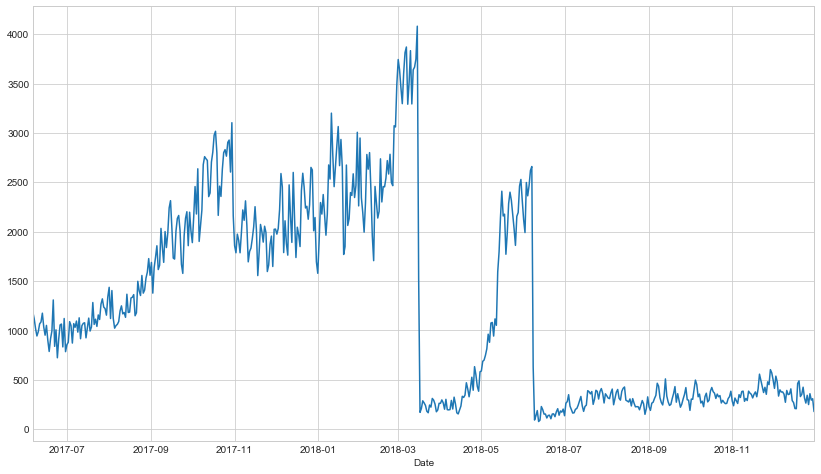

In [18]:
a['Comment'][1249:].plot(figsize= (14,8))

In [20]:
%%time

for i in range(10000000):
    a = i

Wall time: 6.39 s


In [62]:
urlMarket = 'http://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20140101&end=20180315'
df = pd.read_html(urlMarket)[0]
df.index  = [datetime.datetime.strptime(date, '%b %d, %Y') for date in df["Date"]]
df.index.name = 'Date'
df = df.sort_index()


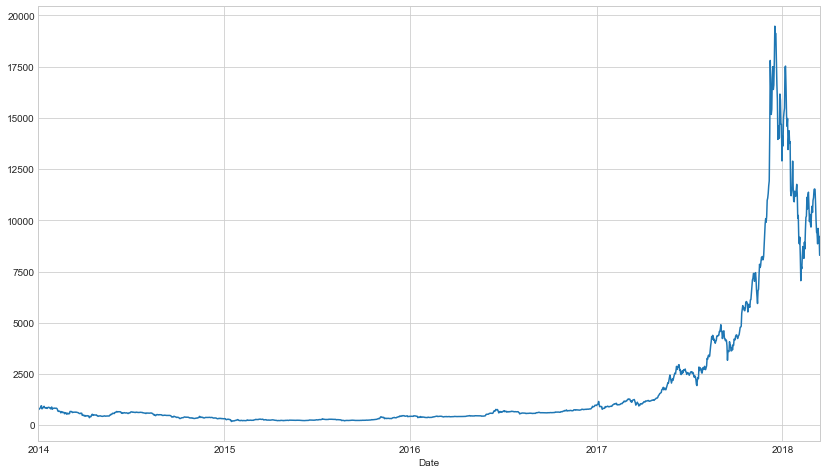

In [63]:
df["Open"].plot(figsize= (14,8))

# DTM

In [7]:
#jei corpuse veikia tai nereikia
import gzip
if 1==0:
    with gzip.open(os.path.join(project_data_path, 'bigram_tokens'), 'wb') as f:
        pickle.dump(bigram_tokens, f, pickle.HIGHEST_PROTOCOL)
else:
    with gzip.open(os.path.join(project_data_path, 'bigram_tokens'), 'rb') as f:
        bigram_tokens = pickle.load(f)


In [3]:
import numpy as np
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.models import ldaseqmodel

In [4]:
comments = pd.read_pickle(os.path.join(project_data_path, "comments"))

FileNotFoundError: [Errno 2] No such file or directory: '..\\project_data\\comments'

In [11]:
dates = comments.index.get_level_values(0)
freq = dates.value_counts()
freq.index = freq.index.to_period("Q")
time_seq =list(freq.groupby(freq.index).sum())

In [8]:
#freq.groupby(freq.index).sum()

In [12]:
class  DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

In [13]:
corpus = DTMcorpus(bigram_tokens)
corpus.dictionary.filter_extremes(no_below=15, no_above=0.5)
len(corpus.dictionary)

40903

In [14]:
del comments, bigram_tokens

In [ ]:
#1000-17min 7s #5000  17min 27s #10000 3h 23min #120000 15:31; 7:47; 12:00 (5.7 GB)
#2h pertrauka (6-8) (1+1+1+0.5)

In [15]:
%%time
print(datetime.datetime.now())
model = DtmModel("dtm-win64.exe", corpus, time_seq, num_topics= 40,
                 id2word=corpus.dictionary, initialize_lda=True)
print(datetime.datetime.now())

2019-01-18 10:15:03.690517
2019-01-20 22:15:16.781639
Wall time: 2d 12h 13s


In [16]:
model.save(os.path.join(project_data_path, 'DTM_40_topics_190101'))

In [ ]:
os.system("start C:/Users/Giedrius/Music/1.mp3")         

In [75]:
model.show_topic(topicid=0, time=0, topn=10)

[(0.064465932639137108, 'bitcoin'),
 (0.020663926285676964, 'price'),
 (0.012316401312520247, 'time'),
 (0.011167687655771147, 'think'),
 (0.010296133986523705, 'buy'),
 (0.0098456211441272611, 'people'),
 (0.0089988883393655635, 'coin'),
 (0.0083147899672369012, 'market'),
 (0.0074638390244143194, 'money'),
 (0.0072530754487325306, 'invest')]

In [4]:
model = DtmModel.load(os.path.join(project_data_path, 'DTM_30_topics'))

NameError: name 'os' is not defined

In [ ]:
freq = df.groupby(["Date", "Topic No."])["Comment"].count()
freq = freq[6768:-170]
freq.to_pickle(os.path.join(project_data_path, 'comm_freq'))